Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


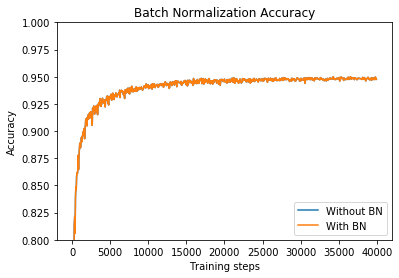

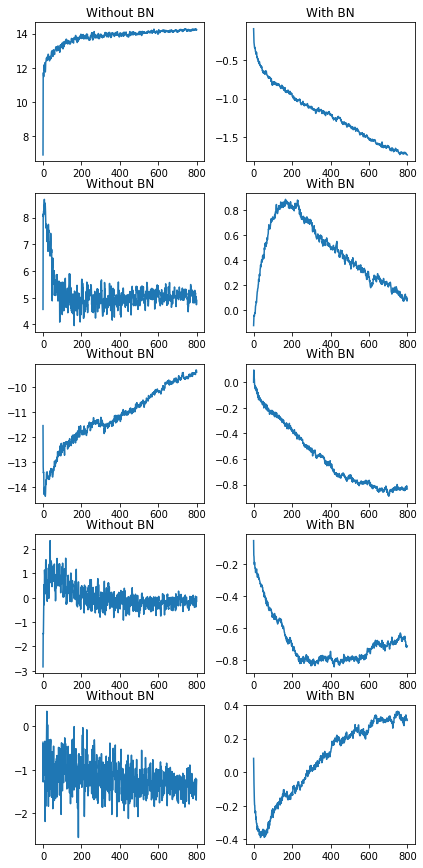

In [26]:
import numpy as np, tensorflow as tf
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

w1_initial = np.random.normal(size=(784, 100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x, w1) + b1
l1 = tf.nn.sigmoid(z1)

# Layer 1 with BN
w1_BN = tf.Variable(w1_initial)
z1_BN = tf.matmul(x, w1_BN)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN, [0])

# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1, w2) + b2
l2 = tf.nn.sigmoid(z2)

# Layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN, w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN, batch_mean2, batch_var2, beta2, scale2, epsilon)
l2_BN = tf.nn.sigmoid(BN2)

# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN = tf.nn.softmax(tf.matmul(l2_BN, w3_BN) + b3_BN)

# Loss, optimizer and predictions
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_ * tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
correct_prediction_BN = tf.equal(tf.argmax(y_BN, 1), tf.argmax(y_, 1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

zs, BNs, acc, acc_BN = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(40000):
    batch = mnist.train.next_batch(60)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    
    if i % 50 is 0:
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2], axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3], axis=0)) # record the mean value of BN2 over the entire test set
        
zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])

In [17]:
import numpy as np
import tensorflow as tf

w = np.arange(6).reshape(2, 3)
w1 = tf.Variable(w, dtype=tf.float32)
mean, var = tf.nn.moments(w1, [0])
w1_hat = (w1 - mean) / tf.sqrt(var)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(sess.run(w1))
    print(sess.run([mean, var]))
    print(sess.run(w1_hat))

[[0. 1. 2.]
 [3. 4. 5.]]
[array([1.5, 2.5, 3.5], dtype=float32), array([2.25, 2.25, 2.25], dtype=float32)]
[[-1. -1. -1.]
 [ 1.  1.  1.]]


In [13]:
import tensorflow as tf

correct_prediction = tf.equal(1, 1)
test = tf.cast(correct_prediction, tf.float32)
sess = tf.InteractiveSession()
print(sess.run(test))

1.0


In [43]:
import numpy as np, tensorflow as tf, tqdm
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

w1_initial = np.random.normal(size=(784, 100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

def batch_norm_wrapper(inputs, is_training, decay=0.999):
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)
    
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)
    
def build_graph(is_training):
    # Placeholders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # Layer 1
    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x, w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)
    
    # Layer 2
    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1, w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)
    
    # Softmax
    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(l2, w3))
    
    # Loss, Optimizer and Predictions
    cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
    
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    return (x, y_), train_step, accuracy, y, tf.train.Saver()

'''
sess.close()
tf.reset_default_graph()
(x, y_), train_step, accuracy, _, saver = build_graph(is_training=True)

acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 50 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc.append(res[0])
    saved_model = saver.save(sess, './temp-bn-save')

print("Final accuracy:", acc[-1])

'''
tf.reset_default_graph()
(x, y_), _, accuracy, y, saver = build_graph(is_training=False)

predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './temp-bn-save')
    for i in range(100):
        pred, corr = sess.run([tf.arg_max(y,1), accuracy],
                             feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
        correct += corr
        predictions.append(pred[0])

print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./temp-bn-save
PREDICTIONS: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 7, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
ACCURACY: 0.98


1.6.0
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
【Training Result:】








  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]




  0%|                                                                              | 1/50000 [00:00<5:17:54,  2.62it/s]




  0%|                                                                             | 51/50000 [00:00<3:42:49,  3.74it/s]




  0%|                                                                             | 72/50000 [00:00<2:37:07,  5.30it/s]




  0%|▏                                                                           | 101/50000 [00:00<1:50:49,  7.50it/s]




  0%|▏                                                                           | 141/50000 [00:00<1:18:09, 10.63it/s]




  0%|▎                                                                             | 175/50000 [00:00<55:24, 14.99it/s]




  0%|▎                                                                             | 204/50000 [00:01<39:44, 20.88it/s]




  0

  5%|███▌                                                                        | 2358/50000 [00:08<02:31, 314.25it/s]




  5%|███▋                                                                        | 2394/50000 [00:09<02:40, 297.44it/s]




  5%|███▋                                                                        | 2427/50000 [00:09<02:48, 281.67it/s]




  5%|███▊                                                                        | 2471/50000 [00:09<02:32, 311.26it/s]




  5%|███▊                                                                        | 2505/50000 [00:09<03:09, 251.08it/s]




  5%|███▉                                                                        | 2556/50000 [00:09<02:40, 295.81it/s]




  5%|███▉                                                                        | 2592/50000 [00:09<03:03, 257.80it/s]




  5%|███▉                                                                        | 2623/50000 [00:09<02:58, 266.12it/s]




  5%|███

  9%|███████                                                                     | 4664/50000 [00:17<04:00, 188.34it/s]




  9%|███████▏                                                                    | 4696/50000 [00:18<03:31, 214.54it/s]




  9%|███████▏                                                                    | 4734/50000 [00:18<03:08, 239.91it/s]




 10%|███████▏                                                                    | 4763/50000 [00:18<03:41, 204.57it/s]




 10%|███████▎                                                                    | 4814/50000 [00:18<03:01, 249.06it/s]




 10%|███████▎                                                                    | 4847/50000 [00:18<03:19, 226.02it/s]




 10%|███████▍                                                                    | 4880/50000 [00:18<03:01, 249.20it/s]




 10%|███████▍                                                                    | 4916/50000 [00:18<02:45, 271.62it/s]




 10%|███

 14%|██████████▋                                                                 | 7044/50000 [00:26<02:36, 274.28it/s]




 14%|██████████▊                                                                 | 7075/50000 [00:26<02:44, 260.70it/s]




 14%|██████████▊                                                                 | 7104/50000 [00:27<02:56, 243.38it/s]




 14%|██████████▊                                                                 | 7154/50000 [00:27<02:36, 274.11it/s]




 14%|██████████▉                                                                 | 7185/50000 [00:27<03:07, 228.93it/s]




 14%|██████████▉                                                                 | 7231/50000 [00:27<02:38, 269.20it/s]




 15%|███████████                                                                 | 7263/50000 [00:27<02:45, 257.65it/s]




 15%|███████████                                                                 | 7293/50000 [00:27<02:53, 246.71it/s]




 15%|███

 19%|██████████████▏                                                             | 9333/50000 [00:35<02:57, 228.52it/s]




 19%|██████████████▎                                                             | 9378/50000 [00:35<02:31, 267.76it/s]




 19%|██████████████▎                                                             | 9410/50000 [00:36<02:38, 256.72it/s]




 19%|██████████████▎                                                             | 9439/50000 [00:36<02:47, 241.54it/s]




 19%|██████████████▍                                                             | 9490/50000 [00:36<02:21, 286.48it/s]




 19%|██████████████▍                                                             | 9524/50000 [00:36<03:03, 220.37it/s]




 19%|██████████████▌                                                             | 9575/50000 [00:36<02:32, 264.91it/s]




 19%|██████████████▌                                                             | 9610/50000 [00:36<02:47, 240.63it/s]




 19%|███

 23%|█████████████████▌                                                         | 11675/50000 [00:44<02:20, 273.59it/s]




 23%|█████████████████▌                                                         | 11705/50000 [00:44<02:28, 258.73it/s]




 24%|█████████████████▋                                                         | 11756/50000 [00:44<02:13, 285.91it/s]




 24%|█████████████████▋                                                         | 11787/50000 [00:45<02:20, 272.90it/s]




 24%|█████████████████▋                                                         | 11816/50000 [00:45<02:31, 252.00it/s]




 24%|█████████████████▊                                                         | 11860/50000 [00:45<02:18, 276.17it/s]




 24%|█████████████████▊                                                         | 11894/50000 [00:45<02:10, 291.35it/s]




 24%|█████████████████▉                                                         | 11925/50000 [00:45<03:52, 163.70it/s]




 24%|███

 28%|████████████████████▉                                                      | 13987/50000 [00:53<02:15, 265.55it/s]




 28%|█████████████████████                                                      | 14019/50000 [00:53<02:28, 243.11it/s]




 28%|█████████████████████                                                      | 14048/50000 [00:53<02:35, 231.83it/s]




 28%|█████████████████████▏                                                     | 14094/50000 [00:54<02:12, 272.01it/s]




 28%|█████████████████████▏                                                     | 14127/50000 [00:54<02:19, 256.59it/s]




 28%|█████████████████████▏                                                     | 14157/50000 [00:54<02:14, 266.29it/s]




 28%|█████████████████████▎                                                     | 14205/50000 [00:54<02:03, 289.73it/s]




 28%|█████████████████████▎                                                     | 14237/50000 [00:54<02:23, 249.07it/s]




 29%|███

 33%|████████████████████████▌                                                  | 16388/50000 [01:02<01:57, 286.71it/s]




 33%|████████████████████████▋                                                  | 16419/50000 [01:02<02:17, 244.96it/s]




 33%|████████████████████████▋                                                  | 16465/50000 [01:03<01:57, 284.53it/s]




 33%|████████████████████████▋                                                  | 16498/50000 [01:03<02:00, 278.98it/s]




 33%|████████████████████████▊                                                  | 16529/50000 [01:03<03:43, 149.84it/s]




 33%|████████████████████████▊                                                  | 16553/50000 [01:03<03:27, 161.48it/s]




 33%|████████████████████████▉                                                  | 16598/50000 [01:03<02:47, 199.48it/s]




 33%|████████████████████████▉                                                  | 16628/50000 [01:03<02:43, 204.27it/s]




 33%|███

 38%|████████████████████████████▏                                              | 18773/50000 [01:12<01:52, 278.78it/s]




 38%|████████████████████████████▏                                              | 18808/50000 [01:12<01:54, 271.59it/s]




 38%|████████████████████████████▎                                              | 18840/50000 [01:12<01:54, 273.06it/s]




 38%|████████████████████████████▎                                              | 18871/50000 [01:12<01:53, 273.66it/s]




 38%|████████████████████████████▍                                              | 18917/50000 [01:12<01:45, 295.51it/s]




 38%|████████████████████████████▍                                              | 18949/50000 [01:12<02:02, 254.43it/s]




 38%|████████████████████████████▍                                              | 18996/50000 [01:12<01:45, 294.07it/s]




 38%|████████████████████████████▌                                              | 19030/50000 [01:13<01:58, 260.93it/s]




 38%|███

 42%|███████████████████████████████▌                                           | 21015/50000 [01:20<02:02, 236.13it/s]




 42%|███████████████████████████████▌                                           | 21048/50000 [01:20<01:52, 257.12it/s]




 42%|███████████████████████████████▌                                           | 21076/50000 [01:21<01:58, 243.21it/s]




 42%|███████████████████████████████▋                                           | 21102/50000 [01:21<03:22, 142.66it/s]




 42%|███████████████████████████████▋                                           | 21150/50000 [01:21<02:39, 180.43it/s]




 42%|███████████████████████████████▊                                           | 21179/50000 [01:21<02:29, 192.30it/s]




 42%|███████████████████████████████▊                                           | 21206/50000 [01:21<02:25, 198.11it/s]




 43%|███████████████████████████████▉                                           | 21256/50000 [01:21<01:58, 241.68it/s]




 43%|███

 47%|██████████████████████████████████▉                                        | 23302/50000 [01:30<01:51, 239.94it/s]




 47%|███████████████████████████████████                                        | 23348/50000 [01:30<01:35, 279.77it/s]




 47%|███████████████████████████████████                                        | 23381/50000 [01:30<01:49, 242.42it/s]




 47%|███████████████████████████████████                                        | 23411/50000 [01:30<01:43, 256.10it/s]




 47%|███████████████████████████████████▏                                       | 23449/50000 [01:30<01:35, 277.21it/s]




 47%|███████████████████████████████████▏                                       | 23480/50000 [01:30<01:46, 248.69it/s]




 47%|███████████████████████████████████▎                                       | 23508/50000 [01:30<01:45, 251.96it/s]




 47%|███████████████████████████████████▎                                       | 23539/50000 [01:30<01:39, 265.89it/s]




 47%|███

 51%|██████████████████████████████████████▎                                    | 25534/50000 [01:38<01:27, 278.98it/s]




 51%|██████████████████████████████████████▎                                    | 25563/50000 [01:38<01:26, 281.60it/s]




 51%|██████████████████████████████████████▍                                    | 25610/50000 [01:39<01:16, 319.61it/s]




 51%|██████████████████████████████████████▍                                    | 25645/50000 [01:39<01:35, 255.30it/s]




 51%|██████████████████████████████████████▌                                    | 25675/50000 [01:39<02:39, 152.63it/s]




 51%|██████████████████████████████████████▌                                    | 25714/50000 [01:39<02:13, 182.35it/s]




 51%|██████████████████████████████████████▌                                    | 25740/50000 [01:39<02:08, 189.50it/s]




 52%|██████████████████████████████████████▋                                    | 25767/50000 [01:39<01:56, 207.76it/s]




 52%|███

 56%|█████████████████████████████████████████▊                                 | 27877/50000 [01:48<01:21, 270.59it/s]




 56%|█████████████████████████████████████████▊                                 | 27911/50000 [01:48<01:26, 255.96it/s]




 56%|█████████████████████████████████████████▉                                 | 27942/50000 [01:48<01:24, 260.75it/s]




 56%|█████████████████████████████████████████▉                                 | 27992/50000 [01:48<01:12, 304.05it/s]




 56%|██████████████████████████████████████████                                 | 28028/50000 [01:48<01:35, 230.05it/s]




 56%|██████████████████████████████████████████                                 | 28078/50000 [01:48<01:20, 273.74it/s]




 56%|██████████████████████████████████████████▏                                | 28114/50000 [01:49<01:36, 227.15it/s]




 56%|██████████████████████████████████████████▏                                | 28162/50000 [01:49<01:21, 269.46it/s]




 56%|███

 60%|█████████████████████████████████████████████▎                             | 30228/50000 [01:57<01:10, 280.33it/s]




 61%|█████████████████████████████████████████████▍                             | 30259/50000 [01:57<01:47, 183.79it/s]




 61%|█████████████████████████████████████████████▍                             | 30290/50000 [01:57<01:37, 202.12it/s]




 61%|█████████████████████████████████████████████▍                             | 30316/50000 [01:57<01:38, 198.87it/s]




 61%|█████████████████████████████████████████████▌                             | 30363/50000 [01:57<01:21, 240.22it/s]




 61%|█████████████████████████████████████████████▌                             | 30394/50000 [01:58<01:23, 234.46it/s]




 61%|█████████████████████████████████████████████▋                             | 30422/50000 [01:58<01:25, 229.71it/s]




 61%|█████████████████████████████████████████████▋                             | 30472/50000 [01:58<01:11, 273.39it/s]




 61%|███

 65%|████████████████████████████████████████████████▌                          | 32410/50000 [02:06<01:03, 278.78it/s]




 65%|████████████████████████████████████████████████▋                          | 32442/50000 [02:06<01:08, 256.14it/s]




 65%|████████████████████████████████████████████████▋                          | 32480/50000 [02:06<01:01, 283.06it/s]




 65%|████████████████████████████████████████████████▊                          | 32512/50000 [02:06<01:04, 269.75it/s]




 65%|████████████████████████████████████████████████▊                          | 32542/50000 [02:06<01:05, 265.12it/s]




 65%|████████████████████████████████████████████████▊                          | 32579/50000 [02:06<01:00, 289.26it/s]




 65%|████████████████████████████████████████████████▉                          | 32610/50000 [02:06<01:04, 270.01it/s]




 65%|████████████████████████████████████████████████▉                          | 32639/50000 [02:07<01:11, 242.75it/s]




 65%|███

 70%|████████████████████████████████████████████████████▏                      | 34796/50000 [02:14<00:52, 288.55it/s]




 70%|████████████████████████████████████████████████████▏                      | 34833/50000 [02:15<00:49, 306.09it/s]




 70%|████████████████████████████████████████████████████▎                      | 34865/50000 [02:15<01:20, 188.77it/s]




 70%|████████████████████████████████████████████████████▎                      | 34891/50000 [02:15<01:17, 193.86it/s]




 70%|████████████████████████████████████████████████████▍                      | 34934/50000 [02:15<01:04, 231.83it/s]




 70%|████████████████████████████████████████████████████▍                      | 34964/50000 [02:15<01:04, 233.86it/s]




 70%|████████████████████████████████████████████████████▍                      | 34999/50000 [02:15<00:59, 250.41it/s]




 70%|████████████████████████████████████████████████████▌                      | 35029/50000 [02:15<00:57, 262.28it/s]




 70%|███

 74%|███████████████████████████████████████████████████████▋                   | 37096/50000 [02:23<00:47, 272.74it/s]




 74%|███████████████████████████████████████████████████████▋                   | 37125/50000 [02:23<00:46, 275.54it/s]




 74%|███████████████████████████████████████████████████████▋                   | 37154/50000 [02:23<00:47, 268.32it/s]




 74%|███████████████████████████████████████████████████████▊                   | 37202/50000 [02:24<00:41, 308.79it/s]




 74%|███████████████████████████████████████████████████████▊                   | 37236/50000 [02:24<00:53, 240.45it/s]




 75%|███████████████████████████████████████████████████████▉                   | 37282/50000 [02:24<00:45, 280.25it/s]




 75%|███████████████████████████████████████████████████████▉                   | 37316/50000 [02:24<00:46, 270.67it/s]




 75%|████████████████████████████████████████████████████████                   | 37347/50000 [02:24<00:49, 256.49it/s]




 75%|███

 79%|███████████████████████████████████████████████████████████                | 39380/50000 [02:32<00:37, 286.48it/s]




 79%|███████████████████████████████████████████████████████████                | 39413/50000 [02:33<00:38, 272.67it/s]




 79%|███████████████████████████████████████████████████████████▏               | 39444/50000 [02:33<01:03, 166.85it/s]




 79%|███████████████████████████████████████████████████████████▏               | 39473/50000 [02:33<00:55, 190.93it/s]




 79%|███████████████████████████████████████████████████████████▎               | 39505/50000 [02:33<00:50, 207.02it/s]




 79%|███████████████████████████████████████████████████████████▎               | 39532/50000 [02:33<00:50, 207.86it/s]




 79%|███████████████████████████████████████████████████████████▎               | 39564/50000 [02:33<00:45, 231.41it/s]




 79%|███████████████████████████████████████████████████████████▍               | 39602/50000 [02:33<00:39, 261.23it/s]




 79%|███

 83%|██████████████████████████████████████████████████████████████▌            | 41716/50000 [02:42<00:29, 278.53it/s]




 83%|██████████████████████████████████████████████████████████████▌            | 41747/50000 [02:42<00:34, 236.88it/s]




 84%|██████████████████████████████████████████████████████████████▋            | 41793/50000 [02:42<00:29, 276.53it/s]




 84%|██████████████████████████████████████████████████████████████▋            | 41826/50000 [02:42<00:31, 259.39it/s]




 84%|██████████████████████████████████████████████████████████████▊            | 41856/50000 [02:42<00:32, 247.83it/s]




 84%|██████████████████████████████████████████████████████████████▊            | 41899/50000 [02:42<00:28, 283.50it/s]




 84%|██████████████████████████████████████████████████████████████▉            | 41931/50000 [02:42<00:31, 257.05it/s]




 84%|██████████████████████████████████████████████████████████████▉            | 41960/50000 [02:43<00:33, 240.54it/s]




 84%|███

 88%|██████████████████████████████████████████████████████████████████         | 44001/50000 [02:51<00:40, 148.44it/s]




 88%|██████████████████████████████████████████████████████████████████         | 44048/50000 [02:51<00:31, 186.61it/s]




 88%|██████████████████████████████████████████████████████████████████         | 44077/50000 [02:51<00:32, 181.44it/s]




 88%|██████████████████████████████████████████████████████████████████▏        | 44106/50000 [02:51<00:28, 203.86it/s]




 88%|██████████████████████████████████████████████████████████████████▏        | 44142/50000 [02:51<00:25, 231.76it/s]




 88%|██████████████████████████████████████████████████████████████████▎        | 44171/50000 [02:51<00:27, 210.37it/s]




 88%|██████████████████████████████████████████████████████████████████▎        | 44219/50000 [02:51<00:22, 252.31it/s]




 89%|██████████████████████████████████████████████████████████████████▍        | 44251/50000 [02:52<00:23, 247.16it/s]




 89%|███

 92%|█████████████████████████████████████████████████████████████████████▎     | 46242/50000 [02:59<00:12, 299.20it/s]




 93%|█████████████████████████████████████████████████████████████████████▍     | 46273/50000 [02:59<00:13, 274.53it/s]




 93%|█████████████████████████████████████████████████████████████████████▍     | 46314/50000 [03:00<00:13, 283.47it/s]




 93%|█████████████████████████████████████████████████████████████████████▌     | 46344/50000 [03:00<00:14, 250.92it/s]




 93%|█████████████████████████████████████████████████████████████████████▌     | 46380/50000 [03:00<00:13, 274.92it/s]




 93%|█████████████████████████████████████████████████████████████████████▌     | 46413/50000 [03:00<00:12, 278.64it/s]




 93%|█████████████████████████████████████████████████████████████████████▋     | 46442/50000 [03:00<00:14, 240.60it/s]




 93%|█████████████████████████████████████████████████████████████████████▋     | 46495/50000 [03:00<00:12, 287.40it/s]




 93%|███

 97%|████████████████████████████████████████████████████████████████████████▉  | 48611/50000 [03:08<00:07, 191.74it/s]




 97%|████████████████████████████████████████████████████████████████████████▉  | 48637/50000 [03:08<00:06, 196.49it/s]




 97%|█████████████████████████████████████████████████████████████████████████  | 48688/50000 [03:09<00:05, 240.34it/s]




 97%|█████████████████████████████████████████████████████████████████████████  | 48720/50000 [03:09<00:05, 240.07it/s]




 98%|█████████████████████████████████████████████████████████████████████████▏ | 48750/50000 [03:09<00:05, 240.82it/s]




 98%|█████████████████████████████████████████████████████████████████████████▏ | 48801/50000 [03:09<00:04, 271.65it/s]




 98%|█████████████████████████████████████████████████████████████████████████▏ | 48833/50000 [03:09<00:04, 267.65it/s]




 98%|█████████████████████████████████████████████████████████████████████████▎ | 48863/50000 [03:09<00:04, 273.03it/s]




 98%|███

Without Batch_Norm: The final accuracy on validation data is 0.0957999974489212







  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]




  0%|                                                                              | 1/50000 [00:00<5:35:25,  2.48it/s]




  0%|                                                                             | 16/50000 [00:00<3:56:33,  3.52it/s]




  0%|                                                                             | 35/50000 [00:00<2:46:52,  4.99it/s]




  0%|                                                                             | 53/50000 [00:00<1:58:12,  7.04it/s]




  0%|                                                                             | 68/50000 [00:00<1:24:31,  9.84it/s]




  0%|▏                                                                            | 87/50000 [00:00<1:00:29, 13.75it/s]




  0%|▏                                                                             | 103/50000 [00:01<44:05, 18.86it/s]




  0

  3%|█▉                                                                          | 1265/50000 [00:08<05:40, 143.22it/s]




  3%|█▉                                                                          | 1293/50000 [00:08<05:07, 158.50it/s]




  3%|█▉                                                                          | 1311/50000 [00:08<05:36, 144.73it/s]




  3%|██                                                                          | 1334/50000 [00:09<07:38, 106.06it/s]




  3%|██                                                                          | 1355/50000 [00:09<06:31, 124.17it/s]




  3%|██                                                                          | 1371/50000 [00:09<06:35, 122.80it/s]




  3%|██                                                                          | 1394/50000 [00:09<05:40, 142.57it/s]




  3%|██▏                                                                         | 1411/50000 [00:09<05:52, 137.92it/s]




  3%|██▏

  5%|███▊                                                                        | 2518/50000 [00:16<06:25, 123.02it/s]




  5%|███▊                                                                        | 2541/50000 [00:17<05:42, 138.40it/s]




  5%|███▉                                                                        | 2558/50000 [00:17<06:15, 126.44it/s]




  5%|███▉                                                                        | 2585/50000 [00:17<05:16, 149.75it/s]




  5%|███▉                                                                        | 2604/50000 [00:17<05:20, 147.74it/s]




  5%|███▉                                                                        | 2622/50000 [00:17<05:32, 142.54it/s]




  5%|████                                                                        | 2640/50000 [00:17<05:12, 151.75it/s]




  5%|████                                                                        | 2657/50000 [00:17<05:40, 138.89it/s]




  5%|███

  8%|█████▋                                                                      | 3765/50000 [00:25<05:15, 146.44it/s]




  8%|█████▊                                                                      | 3783/50000 [00:25<05:00, 154.03it/s]




  8%|█████▊                                                                      | 3800/50000 [00:25<04:55, 156.43it/s]




  8%|█████▊                                                                      | 3819/50000 [00:25<05:04, 151.86it/s]




  8%|█████▊                                                                      | 3836/50000 [00:25<04:57, 155.28it/s]




  8%|█████▊                                                                      | 3854/50000 [00:25<05:10, 148.47it/s]




  8%|█████▉                                                                      | 3870/50000 [00:25<05:08, 149.32it/s]




  8%|█████▉                                                                      | 3890/50000 [00:25<04:46, 160.93it/s]




  8%|███

 10%|███████▌                                                                    | 5015/50000 [00:33<07:12, 104.11it/s]




 10%|███████▋                                                                    | 5028/50000 [00:33<07:07, 105.17it/s]




 10%|███████▋                                                                    | 5055/50000 [00:33<05:49, 128.61it/s]




 10%|███████▋                                                                    | 5072/50000 [00:34<05:49, 128.48it/s]




 10%|███████▋                                                                    | 5088/50000 [00:34<06:05, 122.83it/s]




 10%|███████▊                                                                    | 5116/50000 [00:34<05:20, 140.24it/s]




 10%|███████▊                                                                    | 5133/50000 [00:34<05:36, 133.50it/s]




 10%|███████▊                                                                    | 5156/50000 [00:34<04:54, 152.20it/s]




 10%|███

 13%|█████████▌                                                                  | 6303/50000 [00:42<04:50, 150.21it/s]




 13%|█████████▌                                                                  | 6327/50000 [00:42<04:19, 168.23it/s]




 13%|█████████▋                                                                  | 6346/50000 [00:42<04:35, 158.66it/s]




 13%|█████████▋                                                                  | 6363/50000 [00:42<04:46, 152.05it/s]




 13%|█████████▋                                                                  | 6390/50000 [00:42<04:22, 166.05it/s]




 13%|█████████▋                                                                  | 6408/50000 [00:42<05:08, 141.35it/s]




 13%|█████████▊                                                                  | 6436/50000 [00:42<04:38, 156.63it/s]




 13%|█████████▊                                                                  | 6454/50000 [00:43<05:12, 139.31it/s]




 13%|███

 15%|███████████▌                                                                | 7647/50000 [00:50<04:23, 160.90it/s]




 15%|███████████▋                                                                | 7665/50000 [00:50<04:34, 153.95it/s]




 15%|███████████▋                                                                | 7682/50000 [00:50<04:40, 150.97it/s]




 15%|███████████▋                                                                | 7709/50000 [00:51<04:17, 164.25it/s]




 15%|███████████▋                                                                | 7727/50000 [00:51<04:28, 157.65it/s]




 15%|███████████▊                                                                | 7745/50000 [00:51<04:19, 162.98it/s]




 16%|███████████▊                                                                | 7762/50000 [00:51<07:00, 100.56it/s]




 16%|███████████▊                                                                | 7776/50000 [00:51<06:34, 107.14it/s]




 16%|███

 18%|█████████████▌                                                              | 8922/50000 [00:59<04:09, 164.86it/s]




 18%|█████████████▌                                                              | 8939/50000 [00:59<04:13, 162.22it/s]




 18%|█████████████▌                                                              | 8956/50000 [00:59<04:36, 148.28it/s]




 18%|█████████████▋                                                              | 8984/50000 [00:59<03:58, 172.10it/s]




 18%|█████████████▋                                                              | 9003/50000 [00:59<05:19, 128.21it/s]




 18%|█████████████▋                                                              | 9031/50000 [00:59<04:42, 145.10it/s]




 18%|█████████████▊                                                              | 9049/50000 [00:59<05:16, 129.31it/s]




 18%|█████████████▊                                                              | 9077/50000 [01:00<04:39, 146.55it/s]




 18%|███

 21%|███████████████▍                                                           | 10269/50000 [01:07<04:13, 156.67it/s]




 21%|███████████████▍                                                           | 10286/50000 [01:08<04:29, 147.25it/s]




 21%|███████████████▍                                                           | 10306/50000 [01:08<04:09, 159.24it/s]




 21%|███████████████▍                                                           | 10323/50000 [01:08<04:19, 152.83it/s]




 21%|███████████████▌                                                           | 10339/50000 [01:08<04:32, 145.74it/s]




 21%|███████████████▌                                                           | 10369/50000 [01:08<04:03, 162.88it/s]




 21%|███████████████▌                                                           | 10387/50000 [01:08<04:14, 155.63it/s]




 21%|███████████████▌                                                           | 10409/50000 [01:08<03:53, 169.53it/s]




 21%|███

 23%|█████████████████▎                                                         | 11510/50000 [01:16<05:25, 118.36it/s]




 23%|█████████████████▎                                                         | 11536/50000 [01:16<04:43, 135.58it/s]




 23%|█████████████████▎                                                         | 11552/50000 [01:16<04:49, 132.66it/s]




 23%|█████████████████▎                                                         | 11571/50000 [01:16<04:25, 144.96it/s]




 23%|█████████████████▍                                                         | 11587/50000 [01:16<04:33, 140.27it/s]




 23%|█████████████████▍                                                         | 11603/50000 [01:16<04:33, 140.40it/s]




 23%|█████████████████▍                                                         | 11631/50000 [01:17<03:53, 164.47it/s]




 23%|█████████████████▍                                                         | 11650/50000 [01:17<04:00, 159.45it/s]




 23%|███

 26%|███████████████████▏                                                       | 12779/50000 [01:24<03:44, 166.08it/s]




 26%|███████████████████▏                                                       | 12797/50000 [01:24<03:59, 155.63it/s]




 26%|███████████████████▏                                                       | 12816/50000 [01:24<03:46, 163.82it/s]




 26%|███████████████████▏                                                       | 12833/50000 [01:24<04:03, 152.42it/s]




 26%|███████████████████▎                                                       | 12849/50000 [01:24<04:22, 141.62it/s]




 26%|███████████████████▎                                                       | 12876/50000 [01:25<03:58, 155.57it/s]




 26%|███████████████████▎                                                       | 12893/50000 [01:25<04:10, 148.10it/s]




 26%|███████████████████▎                                                       | 12910/50000 [01:25<04:02, 152.90it/s]




 26%|███

 28%|████████████████████▉                                                      | 13968/50000 [01:32<03:54, 153.41it/s]




 28%|████████████████████▉                                                      | 13985/50000 [01:32<04:02, 148.64it/s]




 28%|█████████████████████                                                      | 14001/50000 [01:32<04:15, 141.16it/s]




 28%|█████████████████████                                                      | 14017/50000 [01:33<04:14, 141.40it/s]




 28%|█████████████████████                                                      | 14032/50000 [01:33<04:15, 140.74it/s]




 28%|█████████████████████                                                      | 14053/50000 [01:33<03:50, 155.94it/s]




 28%|█████████████████████                                                      | 14070/50000 [01:33<03:58, 150.69it/s]




 28%|█████████████████████▏                                                     | 14086/50000 [01:33<04:09, 143.98it/s]




 28%|███

 31%|██████████████████████▉                                                    | 15277/50000 [01:41<03:57, 146.39it/s]




 31%|██████████████████████▉                                                    | 15294/50000 [01:41<04:02, 142.87it/s]




 31%|██████████████████████▉                                                    | 15322/50000 [01:41<03:39, 158.21it/s]




 31%|███████████████████████                                                    | 15340/50000 [01:41<03:39, 158.24it/s]




 31%|███████████████████████                                                    | 15357/50000 [01:41<03:35, 160.80it/s]




 31%|███████████████████████                                                    | 15376/50000 [01:42<03:26, 167.80it/s]




 31%|███████████████████████                                                    | 15394/50000 [01:42<03:52, 148.92it/s]




 31%|███████████████████████▏                                                   | 15422/50000 [01:42<03:20, 172.38it/s]




 31%|███

 33%|████████████████████████▊                                                  | 16572/50000 [01:49<04:00, 139.04it/s]




 33%|████████████████████████▉                                                  | 16598/50000 [01:49<03:36, 154.49it/s]




 33%|████████████████████████▉                                                  | 16615/50000 [01:50<04:02, 137.42it/s]




 33%|████████████████████████▉                                                  | 16636/50000 [01:50<03:39, 152.08it/s]




 33%|████████████████████████▉                                                  | 16653/50000 [01:50<03:55, 141.86it/s]




 33%|█████████████████████████                                                  | 16669/50000 [01:50<04:09, 133.40it/s]




 33%|█████████████████████████                                                  | 16690/50000 [01:50<03:53, 142.85it/s]




 33%|█████████████████████████                                                  | 16707/50000 [01:50<04:03, 136.77it/s]




 33%|███

 36%|██████████████████████████▋                                                | 17829/50000 [01:58<03:24, 157.35it/s]




 36%|███████████████████████████▏                                                | 17846/50000 [01:58<05:44, 93.33it/s]




 36%|███████████████████████████▏                                                | 17859/50000 [01:58<05:23, 99.45it/s]




 36%|██████████████████████████▊                                                | 17886/50000 [01:58<04:33, 117.33it/s]




 36%|██████████████████████████▊                                                | 17905/50000 [01:58<04:03, 132.06it/s]




 36%|██████████████████████████▉                                                | 17921/50000 [01:58<04:20, 123.08it/s]




 36%|██████████████████████████▉                                                | 17948/50000 [01:59<03:38, 146.44it/s]




 36%|██████████████████████████▉                                                | 17966/50000 [01:59<04:28, 119.47it/s]




 36%|███

 38%|████████████████████████████▋                                              | 19104/50000 [02:07<03:37, 141.74it/s]




 38%|████████████████████████████▋                                              | 19122/50000 [02:07<03:24, 151.31it/s]




 38%|████████████████████████████▋                                              | 19138/50000 [02:07<03:37, 141.70it/s]




 38%|████████████████████████████▋                                              | 19153/50000 [02:07<03:34, 143.79it/s]




 38%|████████████████████████████▊                                              | 19173/50000 [02:07<03:16, 156.76it/s]




 38%|████████████████████████████▊                                              | 19190/50000 [02:07<03:16, 156.64it/s]




 38%|████████████████████████████▊                                              | 19207/50000 [02:07<03:38, 141.02it/s]




 38%|████████████████████████████▊                                              | 19234/50000 [02:07<03:07, 163.79it/s]




 39%|███

 41%|██████████████████████████████▌                                            | 20354/50000 [02:15<03:08, 157.08it/s]




 41%|██████████████████████████████▌                                            | 20371/50000 [02:15<03:06, 158.99it/s]




 41%|██████████████████████████████▌                                            | 20388/50000 [02:15<03:17, 150.19it/s]




 41%|██████████████████████████████▌                                            | 20404/50000 [02:15<03:24, 144.63it/s]




 41%|██████████████████████████████▋                                            | 20428/50000 [02:15<03:00, 163.96it/s]




 41%|██████████████████████████████▋                                            | 20446/50000 [02:16<03:12, 153.92it/s]




 41%|██████████████████████████████▋                                            | 20463/50000 [02:16<03:25, 143.86it/s]




 41%|██████████████████████████████▋                                            | 20483/50000 [02:16<03:11, 154.44it/s]




 41%|███

 43%|████████████████████████████████▎                                          | 21579/50000 [02:23<03:37, 130.84it/s]




 43%|████████████████████████████████▍                                          | 21595/50000 [02:24<03:38, 129.96it/s]




 43%|████████████████████████████████▍                                          | 21610/50000 [02:24<03:46, 125.32it/s]




 43%|████████████████████████████████▍                                          | 21638/50000 [02:24<03:09, 149.80it/s]




 43%|████████████████████████████████▍                                          | 21657/50000 [02:24<03:26, 137.53it/s]




 43%|████████████████████████████████▌                                          | 21676/50000 [02:24<03:10, 148.99it/s]




 43%|████████████████████████████████▌                                          | 21693/50000 [02:24<03:14, 145.71it/s]




 43%|████████████████████████████████▌                                          | 21709/50000 [02:24<03:15, 144.96it/s]




 43%|███

 46%|██████████████████████████████████▏                                        | 22799/50000 [02:32<03:25, 132.40it/s]




 46%|██████████████████████████████████▏                                        | 22821/50000 [02:32<03:01, 149.71it/s]




 46%|██████████████████████████████████▎                                        | 22838/50000 [02:32<03:12, 141.10it/s]




 46%|██████████████████████████████████▎                                        | 22854/50000 [02:32<03:16, 138.08it/s]




 46%|██████████████████████████████████▎                                        | 22881/50000 [02:32<02:47, 161.58it/s]




 46%|██████████████████████████████████▎                                        | 22900/50000 [02:32<02:57, 152.61it/s]




 46%|██████████████████████████████████▍                                        | 22917/50000 [02:32<03:00, 149.67it/s]




 46%|██████████████████████████████████▍                                        | 22937/50000 [02:32<02:50, 158.92it/s]




 46%|███

 48%|████████████████████████████████████                                       | 24001/50000 [02:40<02:57, 146.17it/s]




 48%|████████████████████████████████████                                       | 24017/50000 [02:40<02:56, 147.28it/s]




 48%|████████████████████████████████████                                       | 24033/50000 [02:40<02:59, 144.86it/s]




 48%|████████████████████████████████████                                       | 24052/50000 [02:40<02:48, 153.81it/s]




 48%|████████████████████████████████████                                       | 24069/50000 [02:40<02:56, 146.59it/s]




 48%|████████████████████████████████████▏                                      | 24085/50000 [02:40<02:53, 149.52it/s]




 48%|████████████████████████████████████▏                                      | 24104/50000 [02:41<02:43, 158.24it/s]




 48%|████████████████████████████████████▏                                      | 24121/50000 [02:41<02:57, 145.58it/s]




 48%|███

 51%|█████████████████████████████████████▉                                     | 25253/50000 [02:48<02:51, 144.68it/s]




 51%|█████████████████████████████████████▉                                     | 25270/50000 [02:49<02:57, 139.30it/s]




 51%|█████████████████████████████████████▉                                     | 25289/50000 [02:49<02:43, 151.15it/s]




 51%|█████████████████████████████████████▉                                     | 25308/50000 [02:49<02:34, 159.52it/s]




 51%|█████████████████████████████████████▉                                     | 25325/50000 [02:49<02:44, 150.18it/s]




 51%|██████████████████████████████████████                                     | 25344/50000 [02:49<02:34, 159.16it/s]




 51%|██████████████████████████████████████                                     | 25361/50000 [02:49<02:45, 149.17it/s]




 51%|██████████████████████████████████████                                     | 25377/50000 [02:49<02:49, 144.93it/s]




 51%|███

 53%|███████████████████████████████████████▋                                   | 26457/50000 [02:56<02:29, 157.48it/s]




 53%|███████████████████████████████████████▋                                   | 26473/50000 [02:57<02:36, 149.92it/s]




 53%|███████████████████████████████████████▋                                   | 26491/50000 [02:57<02:29, 157.72it/s]




 53%|███████████████████████████████████████▊                                   | 26507/50000 [02:57<02:42, 144.79it/s]




 53%|███████████████████████████████████████▊                                   | 26522/50000 [02:57<02:50, 137.97it/s]




 53%|███████████████████████████████████████▊                                   | 26539/50000 [02:57<02:40, 145.84it/s]




 53%|███████████████████████████████████████▊                                   | 26556/50000 [02:57<02:37, 149.23it/s]




 53%|███████████████████████████████████████▊                                   | 26572/50000 [02:57<02:36, 149.71it/s]




 53%|███

 55%|█████████████████████████████████████████▌                                 | 27683/50000 [03:05<02:14, 165.71it/s]




 55%|█████████████████████████████████████████▌                                 | 27702/50000 [03:05<02:26, 151.83it/s]




 55%|█████████████████████████████████████████▌                                 | 27719/50000 [03:05<02:42, 136.92it/s]




 55%|█████████████████████████████████████████▌                                 | 27743/50000 [03:05<02:22, 156.34it/s]




 56%|█████████████████████████████████████████▋                                 | 27761/50000 [03:06<02:49, 131.25it/s]




 56%|█████████████████████████████████████████▋                                 | 27779/50000 [03:06<02:36, 142.27it/s]




 56%|█████████████████████████████████████████▋                                 | 27796/50000 [03:06<02:28, 149.11it/s]




 56%|█████████████████████████████████████████▋                                 | 27813/50000 [03:06<02:43, 135.37it/s]




 56%|███

 58%|███████████████████████████████████████████▍                               | 28917/50000 [03:13<02:31, 138.76it/s]




 58%|███████████████████████████████████████████▍                               | 28933/50000 [03:14<02:39, 132.11it/s]




 58%|███████████████████████████████████████████▍                               | 28953/50000 [03:14<02:23, 146.21it/s]




 58%|███████████████████████████████████████████▍                               | 28970/50000 [03:14<02:35, 135.60it/s]




 58%|███████████████████████████████████████████▍                               | 28985/50000 [03:14<02:40, 130.95it/s]




 58%|███████████████████████████████████████████▌                               | 29001/50000 [03:14<02:34, 135.78it/s]




 58%|███████████████████████████████████████████▌                               | 29016/50000 [03:14<02:44, 127.74it/s]




 58%|███████████████████████████████████████████▌                               | 29030/50000 [03:14<02:54, 120.16it/s]




 58%|███

 60%|█████████████████████████████████████████████▎                             | 30170/50000 [03:22<01:55, 172.17it/s]




 60%|█████████████████████████████████████████████▎                             | 30188/50000 [03:22<02:01, 162.77it/s]




 60%|█████████████████████████████████████████████▎                             | 30205/50000 [03:22<02:10, 152.19it/s]




 60%|█████████████████████████████████████████████▎                             | 30230/50000 [03:22<01:56, 170.41it/s]




 60%|█████████████████████████████████████████████▎                             | 30249/50000 [03:22<01:54, 173.10it/s]




 61%|█████████████████████████████████████████████▍                             | 30268/50000 [03:22<02:01, 162.08it/s]




 61%|█████████████████████████████████████████████▍                             | 30287/50000 [03:22<01:56, 168.77it/s]




 61%|█████████████████████████████████████████████▍                             | 30305/50000 [03:23<01:59, 164.14it/s]




 61%|███

 63%|███████████████████████████████████████████████▏                           | 31474/50000 [03:30<02:08, 144.08it/s]




 63%|███████████████████████████████████████████████▎                           | 31501/50000 [03:30<02:04, 148.32it/s]




 63%|███████████████████████████████████████████████▎                           | 31517/50000 [03:30<02:14, 137.33it/s]




 63%|███████████████████████████████████████████████▎                           | 31540/50000 [03:30<01:58, 155.67it/s]




 63%|███████████████████████████████████████████████▎                           | 31557/50000 [03:31<02:06, 145.88it/s]




 63%|███████████████████████████████████████████████▎                           | 31573/50000 [03:31<02:24, 127.44it/s]




 63%|████████████████████████████████████████████████                            | 31587/50000 [03:31<03:39, 83.70it/s]




 63%|███████████████████████████████████████████████▍                           | 31613/50000 [03:31<03:00, 102.02it/s]




 63%|███

 66%|█████████████████████████████████████████████████▏                         | 32768/50000 [03:39<01:43, 166.65it/s]




 66%|█████████████████████████████████████████████████▏                         | 32788/50000 [03:39<01:42, 167.20it/s]




 66%|█████████████████████████████████████████████████▏                         | 32806/50000 [03:39<01:51, 154.11it/s]




 66%|█████████████████████████████████████████████████▏                         | 32833/50000 [03:39<01:37, 175.95it/s]




 66%|█████████████████████████████████████████████████▎                         | 32853/50000 [03:39<01:53, 151.25it/s]




 66%|█████████████████████████████████████████████████▎                         | 32871/50000 [03:39<01:47, 158.76it/s]




 66%|█████████████████████████████████████████████████▎                         | 32889/50000 [03:39<01:55, 148.09it/s]




 66%|█████████████████████████████████████████████████▎                         | 32905/50000 [03:40<02:02, 139.63it/s]




 66%|███

 68%|███████████████████████████████████████████████████                        | 34033/50000 [03:47<01:40, 158.24it/s]




 68%|███████████████████████████████████████████████████                        | 34053/50000 [03:47<01:42, 155.56it/s]




 68%|███████████████████████████████████████████████████                        | 34072/50000 [03:47<01:45, 150.93it/s]




 68%|███████████████████████████████████████████████████▏                       | 34091/50000 [03:47<01:39, 160.15it/s]




 68%|███████████████████████████████████████████████████▏                       | 34109/50000 [03:48<01:54, 139.27it/s]




 68%|███████████████████████████████████████████████████▏                       | 34137/50000 [03:48<01:42, 154.85it/s]




 68%|███████████████████████████████████████████████████▏                       | 34155/50000 [03:48<01:49, 144.39it/s]




 68%|███████████████████████████████████████████████████▎                       | 34178/50000 [03:48<01:37, 161.61it/s]




 68%|███

 71%|████████████████████████████████████████████████████▉                      | 35326/50000 [03:56<01:55, 127.33it/s]




 71%|█████████████████████████████████████████████████████                      | 35351/50000 [03:56<01:42, 143.24it/s]




 71%|█████████████████████████████████████████████████████                      | 35368/50000 [03:56<01:54, 127.49it/s]




 71%|█████████████████████████████████████████████████████                      | 35397/50000 [03:56<01:40, 145.06it/s]




 71%|█████████████████████████████████████████████████████                      | 35414/50000 [03:56<01:41, 144.14it/s]




 71%|█████████████████████████████████████████████████████▏                     | 35433/50000 [03:56<01:33, 155.11it/s]




 71%|█████████████████████████████████████████████████████▏                     | 35450/50000 [03:56<01:31, 158.97it/s]




 71%|█████████████████████████████████████████████████████▏                     | 35467/50000 [03:56<01:42, 141.62it/s]




 71%|███

 73%|██████████████████████████████████████████████████████▉                    | 36601/50000 [04:04<01:29, 149.15it/s]




 73%|██████████████████████████████████████████████████████▉                    | 36617/50000 [04:04<01:34, 141.48it/s]




 73%|██████████████████████████████████████████████████████▉                    | 36633/50000 [04:04<01:33, 142.76it/s]




 73%|██████████████████████████████████████████████████████▉                    | 36656/50000 [04:04<01:23, 160.51it/s]




 73%|███████████████████████████████████████████████████████                    | 36674/50000 [04:04<01:27, 152.94it/s]




 73%|███████████████████████████████████████████████████████                    | 36691/50000 [04:05<01:31, 146.04it/s]




 73%|███████████████████████████████████████████████████████                    | 36715/50000 [04:05<01:23, 158.69it/s]




 73%|███████████████████████████████████████████████████████                    | 36733/50000 [04:05<01:23, 158.58it/s]




 74%|███

 76%|████████████████████████████████████████████████████████▊                  | 37869/50000 [04:12<01:22, 147.62it/s]




 76%|████████████████████████████████████████████████████████▊                  | 37885/50000 [04:12<01:21, 148.57it/s]




 76%|████████████████████████████████████████████████████████▊                  | 37901/50000 [04:13<01:20, 151.08it/s]




 76%|████████████████████████████████████████████████████████▉                  | 37917/50000 [04:13<01:26, 139.77it/s]




 76%|████████████████████████████████████████████████████████▉                  | 37934/50000 [04:13<01:22, 146.99it/s]




 76%|████████████████████████████████████████████████████████▉                  | 37955/50000 [04:13<01:16, 157.98it/s]




 76%|████████████████████████████████████████████████████████▉                  | 37973/50000 [04:13<01:13, 162.79it/s]




 76%|████████████████████████████████████████████████████████▉                  | 37990/50000 [04:13<01:21, 147.84it/s]




 76%|███

 78%|██████████████████████████████████████████████████████████▋                | 39095/50000 [04:21<01:10, 155.36it/s]




 78%|██████████████████████████████████████████████████████████▋                | 39112/50000 [04:21<01:22, 132.44it/s]




 78%|██████████████████████████████████████████████████████████▋                | 39140/50000 [04:21<01:09, 156.85it/s]




 78%|██████████████████████████████████████████████████████████▋                | 39159/50000 [04:21<01:16, 142.58it/s]




 78%|██████████████████████████████████████████████████████████▊                | 39180/50000 [04:21<01:09, 156.73it/s]




 78%|██████████████████████████████████████████████████████████▊                | 39198/50000 [04:21<01:12, 148.65it/s]




 78%|██████████████████████████████████████████████████████████▊                | 39215/50000 [04:22<01:13, 145.85it/s]




 78%|██████████████████████████████████████████████████████████▊                | 39242/50000 [04:22<01:07, 159.41it/s]




 79%|███

 81%|████████████████████████████████████████████████████████████▌              | 40345/50000 [04:29<00:59, 161.02it/s]




 81%|████████████████████████████████████████████████████████████▌              | 40363/50000 [04:29<00:58, 164.13it/s]




 81%|████████████████████████████████████████████████████████████▌              | 40380/50000 [04:29<01:09, 138.81it/s]




 81%|████████████████████████████████████████████████████████████▌              | 40407/50000 [04:29<00:59, 161.70it/s]




 81%|████████████████████████████████████████████████████████████▋              | 40426/50000 [04:30<01:07, 141.15it/s]




 81%|████████████████████████████████████████████████████████████▋              | 40444/50000 [04:30<01:03, 150.64it/s]




 81%|████████████████████████████████████████████████████████████▋              | 40461/50000 [04:30<01:02, 152.73it/s]




 81%|████████████████████████████████████████████████████████████▋              | 40478/50000 [04:30<01:03, 149.36it/s]




 81%|███

 83%|██████████████████████████████████████████████████████████████▍            | 41607/50000 [04:37<00:51, 161.99it/s]




 83%|██████████████████████████████████████████████████████████████▍            | 41625/50000 [04:37<00:54, 152.32it/s]




 83%|██████████████████████████████████████████████████████████████▍            | 41642/50000 [04:38<00:58, 143.08it/s]




 83%|██████████████████████████████████████████████████████████████▍            | 41665/50000 [04:38<00:52, 157.49it/s]




 83%|███████████████████████████████████████████████████████████████▎            | 41682/50000 [04:38<01:31, 90.98it/s]




 83%|███████████████████████████████████████████████████████████████▍            | 41696/50000 [04:38<01:26, 96.47it/s]




 83%|██████████████████████████████████████████████████████████████▌            | 41721/50000 [04:38<01:12, 114.42it/s]




 83%|██████████████████████████████████████████████████████████████▌            | 41736/50000 [04:38<01:10, 118.04it/s]




 84%|███

 86%|████████████████████████████████████████████████████████████████▏          | 42828/50000 [04:46<00:46, 155.84it/s]




 86%|████████████████████████████████████████████████████████████████▎          | 42846/50000 [04:46<00:47, 149.57it/s]




 86%|████████████████████████████████████████████████████████████████▎          | 42862/50000 [04:46<00:50, 140.62it/s]




 86%|████████████████████████████████████████████████████████████████▎          | 42891/50000 [04:46<00:42, 165.83it/s]




 86%|████████████████████████████████████████████████████████████████▎          | 42910/50000 [04:46<00:48, 147.32it/s]




 86%|████████████████████████████████████████████████████████████████▍          | 42928/50000 [04:46<00:45, 155.51it/s]




 86%|████████████████████████████████████████████████████████████████▍          | 42946/50000 [04:46<00:44, 157.57it/s]




 86%|████████████████████████████████████████████████████████████████▍          | 42963/50000 [04:47<00:49, 142.25it/s]




 86%|███

 88%|██████████████████████████████████████████████████████████████████▏        | 44143/50000 [04:54<00:37, 157.21it/s]




 88%|██████████████████████████████████████████████████████████████████▏        | 44160/50000 [04:54<00:38, 153.15it/s]




 88%|██████████████████████████████████████████████████████████████████▎        | 44177/50000 [04:54<00:37, 154.10it/s]




 88%|██████████████████████████████████████████████████████████████████▎        | 44201/50000 [04:55<00:33, 171.63it/s]




 88%|██████████████████████████████████████████████████████████████████▎        | 44220/50000 [04:55<00:36, 159.55it/s]




 88%|██████████████████████████████████████████████████████████████████▎        | 44237/50000 [04:55<00:38, 149.41it/s]




 89%|██████████████████████████████████████████████████████████████████▍        | 44255/50000 [04:55<00:36, 155.51it/s]




 89%|██████████████████████████████████████████████████████████████████▍        | 44272/50000 [04:55<00:36, 156.12it/s]




 89%|███

 91%|████████████████████████████████████████████████████████████████████       | 45406/50000 [05:03<00:33, 138.17it/s]




 91%|████████████████████████████████████████████████████████████████████▏      | 45422/50000 [05:03<00:36, 123.81it/s]




 91%|████████████████████████████████████████████████████████████████████▏      | 45451/50000 [05:03<00:30, 148.88it/s]




 91%|████████████████████████████████████████████████████████████████████▏      | 45470/50000 [05:03<00:33, 136.40it/s]




 91%|████████████████████████████████████████████████████████████████████▏      | 45493/50000 [05:03<00:29, 155.14it/s]




 91%|████████████████████████████████████████████████████████████████████▎      | 45512/50000 [05:03<00:32, 139.10it/s]




 91%|████████████████████████████████████████████████████████████████████▎      | 45529/50000 [05:03<00:32, 138.60it/s]




 91%|████████████████████████████████████████████████████████████████████▎      | 45550/50000 [05:04<00:29, 152.42it/s]




 91%|███

 93%|█████████████████████████████████████████████████████████████████████▉     | 46651/50000 [05:11<00:20, 162.52it/s]




 93%|██████████████████████████████████████████████████████████████████████     | 46670/50000 [05:11<00:19, 169.11it/s]




 93%|██████████████████████████████████████████████████████████████████████     | 46688/50000 [05:11<00:21, 155.04it/s]




 93%|██████████████████████████████████████████████████████████████████████     | 46704/50000 [05:11<00:22, 148.36it/s]




 93%|██████████████████████████████████████████████████████████████████████     | 46731/50000 [05:11<00:20, 162.66it/s]




 93%|██████████████████████████████████████████████████████████████████████     | 46748/50000 [05:11<00:21, 153.35it/s]




 94%|██████████████████████████████████████████████████████████████████████▏    | 46766/50000 [05:12<00:20, 158.90it/s]




 94%|██████████████████████████████████████████████████████████████████████▏    | 46784/50000 [05:12<00:19, 162.14it/s]




 94%|███

 96%|███████████████████████████████████████████████████████████████████████▊   | 47910/50000 [05:19<00:14, 142.79it/s]




 96%|███████████████████████████████████████████████████████████████████████▉   | 47935/50000 [05:19<00:12, 163.00it/s]




 96%|███████████████████████████████████████████████████████████████████████▉   | 47953/50000 [05:19<00:13, 149.57it/s]




 96%|███████████████████████████████████████████████████████████████████████▉   | 47970/50000 [05:19<00:14, 140.67it/s]




 96%|███████████████████████████████████████████████████████████████████████▉   | 47995/50000 [05:20<00:12, 161.67it/s]




 96%|████████████████████████████████████████████████████████████████████████   | 48013/50000 [05:20<00:16, 118.54it/s]




 96%|████████████████████████████████████████████████████████████████████████   | 48040/50000 [05:20<00:14, 139.94it/s]




 96%|████████████████████████████████████████████████████████████████████████   | 48058/50000 [05:20<00:15, 127.21it/s]




 96%|███

 98%|█████████████████████████████████████████████████████████████████████████▊ | 49215/50000 [05:28<00:05, 153.20it/s]




 98%|█████████████████████████████████████████████████████████████████████████▊ | 49232/50000 [05:28<00:05, 143.98it/s]




 98%|█████████████████████████████████████████████████████████████████████████▊ | 49248/50000 [05:28<00:05, 148.14it/s]




 99%|█████████████████████████████████████████████████████████████████████████▉ | 49267/50000 [05:28<00:04, 157.16it/s]




 99%|█████████████████████████████████████████████████████████████████████████▉ | 49284/50000 [05:28<00:04, 149.89it/s]




 99%|█████████████████████████████████████████████████████████████████████████▉ | 49301/50000 [05:29<00:04, 154.25it/s]




 99%|█████████████████████████████████████████████████████████████████████████▉ | 49319/50000 [05:29<00:04, 156.25it/s]




 99%|██████████████████████████████████████████████████████████████████████████ | 49335/50000 [05:29<00:04, 147.90it/s]




 99%|███

With Batch Norm: The final accuracy on validation data is 0.7730000019073486

【Testing Result:】

Without Batch_Norm: The final accuracy on test data is 0.09799999743700027
With Batch Norm: The final accuracy on test data is 0.7888000011444092


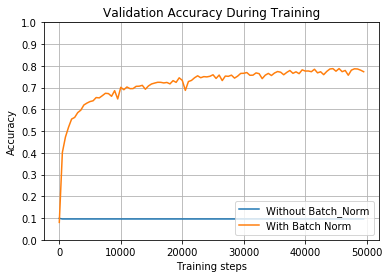

In [49]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

print(tf.__version__)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

class NeuralNetWork():
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch_Norm"
        
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        
        self.training_accuracies = []
        self.build_network(initial_weights, activation_fn)
        
    def build_network(self, initial_weights, activation_fn):
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        
        for layer_weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, layer_weights, activation_fn)
        
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
        
    def fully_connected(self, layer_in, layer_weights, activation_fn=None):
        if self.use_batch_norm and activation_fn:
            weights = tf.Variable(layer_weights)
            linear_output = tf.matmul(layer_in, weights)
            
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
            return activation_fn(batch_normalized_output)
        else:
            weights = tf.Variable(layer_weights)
            bias = tf.Variable(tf.zeros([layer_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), bias)

            return activation_fn(linear_output) if activation_fn else linear_output
        
    def train(self, sess, learning_rate, training_batches, batches_per_validate_data, save_model=None):
        # 定义输出label
        labels = tf.placeholder(tf.float32, [None, 10])
        
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, 
                                                                                  logits=self.output_layer))
        # 准确率
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        if self.use_batch_norm:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            
        # 显示进度条
        for i in tqdm(range(training_batches)):
            batch_x, batch_y = mnist.train.next_batch(60)
            sess.run(train_step, feed_dict={self.input_layer: batch_x,
                                            labels: batch_y,
                                            self.is_training: True})
            if i % batches_per_validate_data == 0:
                val_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                              labels: mnist.validation.labels,
                                                              self.is_training: False})
                self.training_accuracies.append(val_accuracy)
        print("{}: The final accuracy on validation data is {}".format(self.name, val_accuracy))
        
        if save_model:
            tf.train.Saver().save(sess, save_model)
        
    def test(self, sess, test_training_accuracy=False, restore=None):
        # 定义label
        labels = tf.placeholder(tf.float32, [None, 10])
        
        # 准确率
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # 是否加载模型
        if restore:
            tf.train.Saver().restore(sess, restore)
        
        test_accuracy = sess.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                      labels: mnist.test.labels,
                                                      self.is_training: False})
        
        print("{}: The final accuracy on test data is {}".format(self.name, test_accuracy))
        

def plot_training_accuracies(*args, batches_per_validate_data):
    """
    绘制模型在训练过程中的准确率曲线
    
    :param args: 一个或多个NeuralNetWork对象
    :param batches_per_validate_data: 训练多少个batch进行一次数据验证
    """
    fig, ax = plt.subplots()
    
    for nn in args:
        ax.plot(range(0, len(nn.training_accuracies)*batches_per_validate_data, batches_per_validate_data),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

def train_and_test(use_larger_weights, learning_rate, activation_fn, training_batches=50000, batches_per_validate_data=500):
    """
    使用相同的权重初始化生成两个网络对象，其中一个使用BN，另一个不使用BN
    
    :param use_larger_weights: 是否使用更大的权重
    :param learning_rate: 学习率
    :param activation_fn: 激活函数
    :param training_batches: 训练阶段使用的batch数（默认为50000）
    :param batches_per_validate_data: 训练多少个batch后在validation数据上进行测试
    """
    if use_larger_weights:
        weights = [np.random.normal(size=(784,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,10), scale=10.0).astype(np.float32)
                  ]
    else:
        weights = [np.random.normal(size=(784,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,10), scale=0.05).astype(np.float32)
                  ]

    tf.reset_default_graph()

    nn = NeuralNetWork(weights, activation_fn, use_batch_norm=False) # Without BN
    bn = NeuralNetWork(weights, activation_fn, use_batch_norm=True) # With BN
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        print("【Training Result:】\n")
        
        nn.train(sess, learning_rate, training_batches, batches_per_validate_data)
        bn.train(sess, learning_rate, training_batches, batches_per_validate_data)
        
        print("\n【Testing Result:】\n")
        nn.test(sess)
        bn.test(sess)
    
    plot_training_accuracies(nn, bn, batches_per_validate_data=batches_per_validate_data)


train_and_test(use_larger_weights=True, learning_rate=0.01, activation_fn=tf.nn.relu)